# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
import torchvision
MNIST = torchvision.datasets.MNIST(".", download=True)
data = MNIST.train_data
labels = MNIST.train_labels

data = data.view(data.shape[0], -1).numpy()
labels = labels.numpy()

c:\Users\pmiha\anaconda3\envs\MLFlow_env\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\pmiha\anaconda3\envs\MLFlow_env\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [3]:
indices = np.random.choice(data.shape[0], 20000, replace=False)
data = data[indices]
labels = labels[indices]

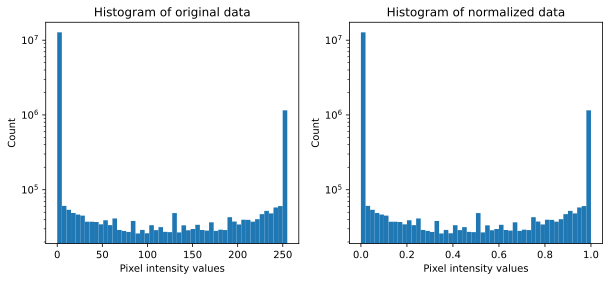

In [4]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')


ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

# Create train/test groups using DataLoader

In [5]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [7]:
# check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
MNIST               MNIST            Dataset MNIST\n    Number<...>tion: .\n    Split: Train
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchsize           int              32
data                ndarray          20000x784: 15680000 elems, type `uint8`, 15680000 bytes (14.95361328125 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                 Figure           Figure(1000x400)
indices             ndarray          20000: 20000 elems, type

# Create the DL model

In [19]:
# create a class for the model
def createTheMNISTNet(nUnits,nLayers):

  class mnistNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784,nUnits)

      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,10)


    # forward pass
    def forward(self,x):
      x = F.relu( self.layers["input"](x) )
      
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      x = self.layers['output'](x)
      return x

  # create the model instance
  net = mnistNet(nUnits,nLayers)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [7]:
next(iter(test_loader))

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 7, 4,  ..., 4, 0, 5])]

In [17]:
nUnitsPerLayer = 12
nLayers = 4

In [20]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(nUnitsPerLayer,nLayers)
net


mnistNet(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=10, bias=True)
  )
)

# Create a function that trains the model

In [22]:
# a function that trains the model

def function2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [23]:
trainAcc,testAcc,losses,net = function2trainTheModel(nUnits=16,nLayers=2)


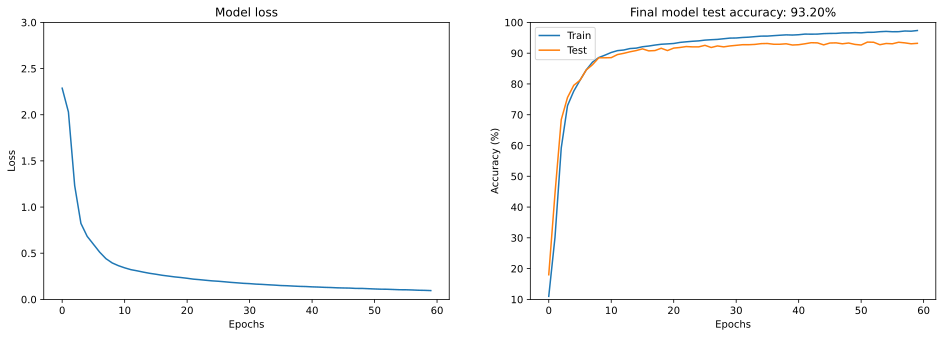

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [26]:
for i in range(1,4):
    print(i)

1
2
3


In [28]:
# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50)

np.zeros((2,len(numunits),len(numlayers)))

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [29]:
# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = function2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}') 

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


In [34]:
accuracies

array([[[98.33407593, 99.5140152 , 99.90658569],
        [98.84230042, 99.68527985, 99.97664642],
        [98.96686554, 99.83763123, 99.97554016],
        [99.07139587, 99.85876465, 99.98110199],
        [99.24044037, 99.90992737, 99.99888611]],

       [[94.5       , 94.74000549, 94.65000153],
        [95.73000336, 95.36000061, 95.45999908],
        [95.8299942 , 95.93000793, 95.65999603],
        [95.58000183, 95.56999969, 95.83000183],
        [95.95000458, 95.91000366, 96.02000427]]])

In [33]:
numunits

array([ 50, 100, 150, 200, 250])

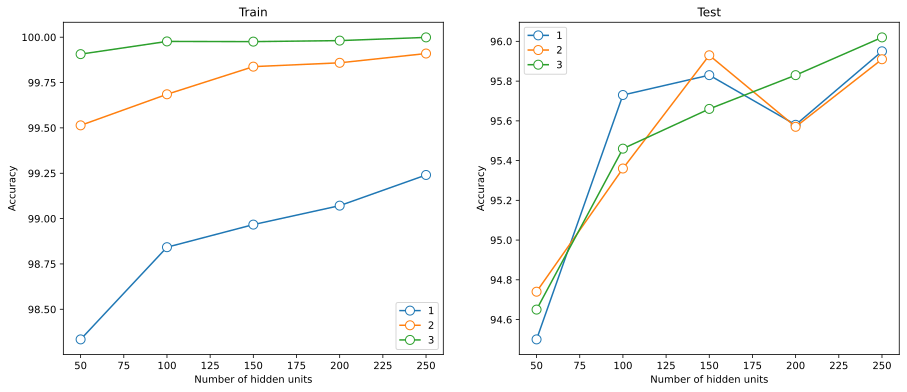

In [37]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()

# Inspect the results in more detail

In [13]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

torch.exp(predictions)

tensor([[4.9692e-10, 1.5918e-07, 3.2915e-09,  ..., 1.5117e-04, 4.7932e-03,
         8.9765e-01],
        [3.1158e-19, 3.9841e-09, 2.2554e-07,  ..., 8.4483e-11, 3.9543e-13,
         1.2735e-14],
        [1.1630e-10, 8.7947e-06, 9.9998e-01,  ..., 7.9919e-06, 1.0065e-06,
         2.0656e-13],
        ...,
        [2.0382e-13, 9.9990e-01, 2.2186e-05,  ..., 2.6815e-07, 4.6870e-05,
         1.7214e-10],
        [4.8741e-10, 4.6235e-09, 3.1878e-07,  ..., 6.6528e-09, 1.0000e+00,
         8.0291e-09],
        [1.5086e-14, 2.0328e-08, 9.1034e-09,  ..., 1.6212e-08, 1.2760e-09,
         4.3185e-09]])

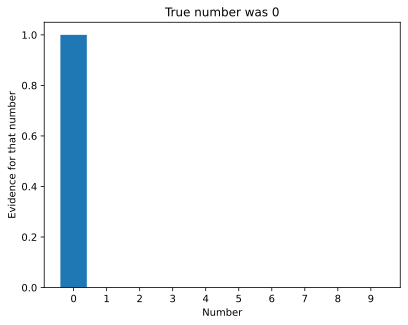

In [15]:
# Evidence for all numbers from one sample
sample2show = 125

plt.bar(range(10),torch.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

Indices where both predicted and true labels are 7: tensor([  21,   33,   35,   38,   59,   89,  122,  126,  127,  158,  163,  166,
         196,  200,  206,  210,  229,  231,  250,  258,  260,  263,  268,  287,
         322,  325,  331,  336,  338,  344,  372,  385,  387,  388,  402,  405,
         410,  416,  426,  452,  453,  456,  459,  467,  473,  476,  483,  486,
         511,  512,  519,  534,  539,  547,  552,  570,  611,  621,  632,  642,
         648,  652,  678,  684,  694,  710,  721,  725,  727,  739,  751,  765,
         772,  777,  805,  809,  817,  826,  830,  835,  847,  860,  873,  883,
         890,  898,  908,  915,  922,  928,  934,  935,  936,  939,  948,  949,
         964,  992,  994,  995,  999, 1013, 1016, 1032, 1038, 1050, 1054, 1086,
        1087, 1104, 1109, 1120, 1125, 1136, 1141, 1144, 1166, 1169, 1177, 1189,
        1200, 1228, 1268, 1284, 1328, 1344, 1346, 1347, 1374, 1386, 1405, 1411,
        1413, 1416, 1420, 1438, 1447, 1449, 1455, 1480, 1498, 1502, 

[  23   43   90  112  185  238  244  271  282  286  300  310  311  324
  393  406  411  413  420  446  475  486  504  522  524  531  553  570
  571  612  623  658  660  742  757  790  892  903  928 1006 1010 1028
 1060 1075 1179 1241 1277 1314 1330 1353 1389 1433 1484 1501 1531 1557
 1597 1619 1649 1692 1715 1738 1771 1777 1790 1797 1800 1805 1815 1838
 1855 1890 1907 1929]


C:\Users\pmiha\AppData\Local\Temp\ipykernel_8516\4150860644.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


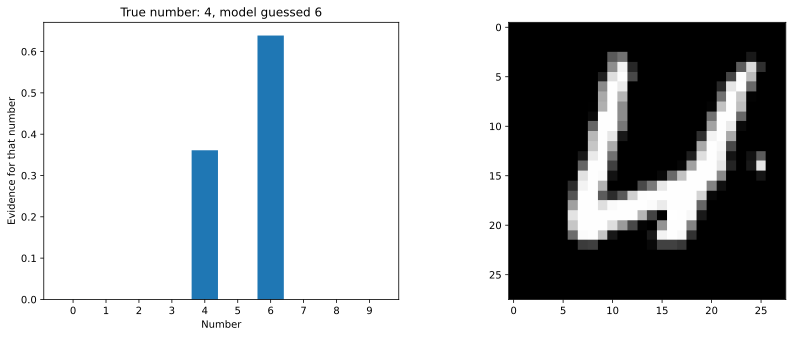

In [16]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 12

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 

In [ ]:
predicted_labels = torch.max(predictions, axis=1)[1]

Indices of almost errors: tensor([  30,   31,   51,   67,  174,  176,  181,  219,  229,  251,  262,  269,
         284,  297,  334,  362,  388,  457,  480,  481,  484,  507,  516,  520,
         532,  574,  575,  605,  608,  615,  619,  636,  666,  690,  698,  728,
         759,  809,  819,  822,  846,  873,  880,  919,  973,  977, 1002, 1029,
        1043, 1073, 1087, 1099, 1146, 1156, 1189, 1207, 1213, 1289, 1306, 1319,
        1331, 1367, 1411, 1428, 1590, 1615, 1633, 1671, 1695, 1716, 1726, 1728,
        1767, 1866, 1913, 1931, 1963, 1988, 1990, 1995])


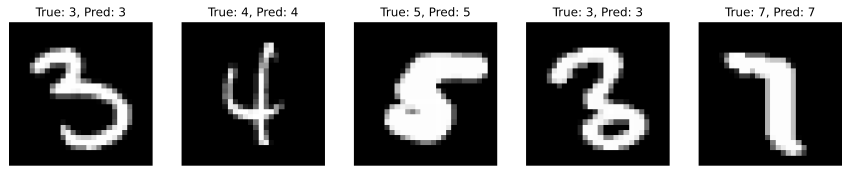

In [23]:
# Convert log probabilities to probabilities
probabilities = torch.exp(predictions)

# Identify correct categorizations
correct_categorizations = predicted_labels == y

# Initialize a list to store indices of almost errors
almost_errors_indices = []

# Loop through each correct categorization
for i in range(len(correct_categorizations)):
    if correct_categorizations[i]:
        # Get the predicted label
        predicted_label = predicted_labels[i]
        
        # Get the probabilities for all other labels
        other_probabilities = probabilities[i][probabilities[i] != probabilities[i][predicted_label]]
        
        # Check if any other probability exceeds 0.1
        if torch.any(other_probabilities > 0.1):
            almost_errors_indices.append(i)

# Convert to tensor
almost_errors_indices = torch.tensor(almost_errors_indices)

# Print the indices of almost errors
print("Indices of almost errors:", almost_errors_indices)

# Extract the data for the almost errors from the test dataset
almost_errors_data = test_data.tensors[0][almost_errors_indices]

# Plot the images of some almost errors
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(almost_errors_data[i].reshape(28, 28), cmap='gray')
    ax[i].set_title(f"True: {y[almost_errors_indices[i]].item()}, Pred: {predicted_labels[almost_errors_indices[i]].item()}")
    ax[i].axis('off')

plt.show()

In [22]:
predictions

tensor([[-2.1423e+01, -1.5653e+01, -1.9532e+01,  ..., -8.7971e+00,
         -5.3406e+00, -1.0798e-01],
        [-4.2613e+01, -1.9341e+01, -1.5305e+01,  ..., -2.3194e+01,
         -2.8559e+01, -3.1994e+01],
        [-2.2875e+01, -1.1641e+01, -2.2769e-05,  ..., -1.1737e+01,
         -1.3809e+01, -2.9208e+01],
        ...,
        [-2.9222e+01, -9.5720e-05, -1.0716e+01,  ..., -1.5132e+01,
         -9.9681e+00, -2.2483e+01],
        [-2.1442e+01, -1.9192e+01, -1.4959e+01,  ..., -1.8828e+01,
         -4.7684e-06, -1.8640e+01],
        [-3.1825e+01, -1.7711e+01, -1.8515e+01,  ..., -1.7938e+01,
         -2.0480e+01, -1.9260e+01]])

In [17]:
# Get the predicted labels
predicted_labels = torch.max(predictions, axis=1)[1]

# Elements where both predicted and true labels are 7
correct_7s = (predicted_labels == 7) & (y == 7)

# Elements where true labels are 7 but predicted labels are not 7
incorrect_7s = (y != 7) & (predicted_labels == 7)

# Extract the indices
correct_7s_indices = torch.where(correct_7s)[0]
incorrect_7s_indices = torch.where(incorrect_7s)[0]

print("Indices where both predicted and true labels are 7:", correct_7s_indices)
print("Indices where true labels are 7 but predicted labels are not 7:", incorrect_7s_indices)

Indices where both predicted and true labels are 7: tensor([   4,    9,   13,   25,   46,   48,   59,   60,   80,   95,  121,  128,
         134,  149,  159,  160,  165,  168,  174,  186,  189,  220,  227,  235,
         236,  260,  263,  292,  301,  303,  307,  317,  334,  351,  359,  372,
         375,  397,  428,  435,  440,  444,  451,  452,  454,  456,  460,  461,
         478,  489,  501,  521,  556,  562,  579,  598,  608,  637,  638,  641,
         644,  654,  685,  690,  719,  724,  727,  728,  744,  751,  753,  755,
         769,  770,  800,  815,  821,  841,  843,  845,  858,  874,  875,  904,
         912,  918,  926,  953,  962,  964,  971,  973,  978,  985,  987,  999,
        1009, 1025, 1034, 1037, 1043, 1058, 1059, 1070, 1079, 1082, 1099, 1105,
        1114, 1116, 1141, 1142, 1148, 1157, 1159, 1166, 1177, 1187, 1192, 1198,
        1225, 1232, 1250, 1270, 1271, 1283, 1291, 1292, 1294, 1299, 1303, 1320,
        1325, 1326, 1344, 1354, 1357, 1358, 1363, 1380, 1387, 1391, 

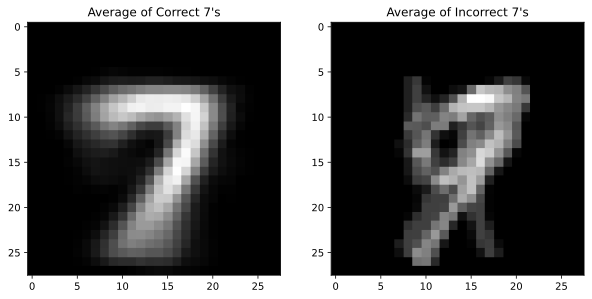

In [18]:
# Extract the data for the correct 7's and the error 7's from the test dataset
correct_7s_data = test_data.tensors[0][correct_7s_indices]
incorrect_7s_data = test_data.tensors[0][incorrect_7s_indices]

# Compute the average of each group
average_correct_7s = torch.mean(correct_7s_data, axis=0).numpy()
average_incorrect_7s = torch.mean(incorrect_7s_data, axis=0).numpy()

# Reshape the averaged data to 28x28 images
average_correct_7s_image = np.reshape(average_correct_7s, (28, 28))
average_incorrect_7s_image = np.reshape(average_incorrect_7s, (28, 28))

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(average_correct_7s_image, cmap='gray')
ax[0].set_title("Average of Correct 7's")

ax[1].imshow(average_incorrect_7s_image, cmap='gray')
ax[1].set_title("Average of Incorrect 7's")

plt.show()

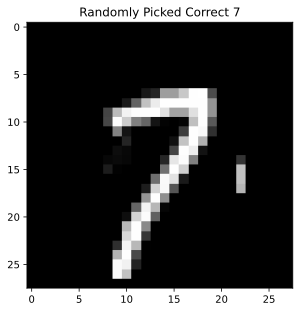

In [19]:
# Pick a random index from the correct_7s_indices
random_index = np.random.choice(correct_7s_indices)

# Extract the corresponding image data
# Extract the corresponding image data from the test dataset
random_correct_7_image = test_data.tensors[0][random_index].reshape(28, 28)

# Plot the image
plt.imshow(random_correct_7_image, cmap='gray')
plt.title("Randomly Picked Correct 7")
plt.show()

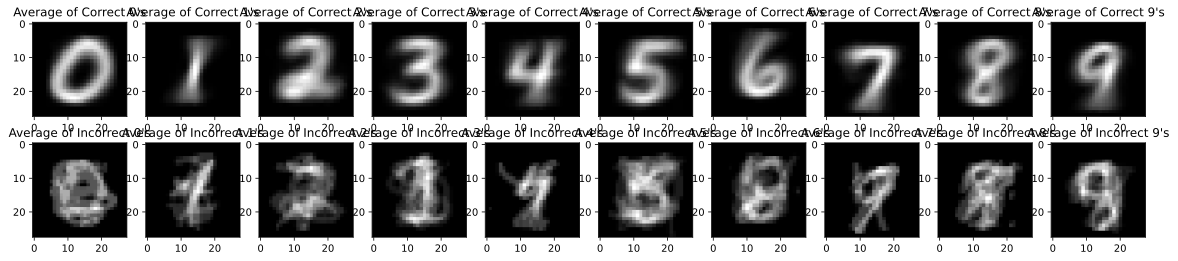

In [20]:
# Plot the images
fig, ax = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Elements where both predicted and true labels are i
    correct_i = (predicted_labels == i) & (y == i)
    
    # Elements where true labels are i but predicted labels are not i
    incorrect_i = (y != i) & (predicted_labels == i)
    
    # Extract the indices
    correct_i_indices = torch.where(correct_i)[0]
    incorrect_i_indices = torch.where(incorrect_i)[0]
    
    # Extract the data for the correct i's and the error i's from the test dataset
    correct_i_data = test_data.tensors[0][correct_i_indices]
    incorrect_i_data = test_data.tensors[0][incorrect_i_indices]
    
    # Compute the average of each group
    average_correct_i = torch.mean(correct_i_data, axis=0).numpy()
    average_incorrect_i = torch.mean(incorrect_i_data, axis=0).numpy()
    
    # Reshape the averaged data to 28x28 images
    average_correct_i_image = np.reshape(average_correct_i, (28, 28))
    average_incorrect_i_image = np.reshape(average_incorrect_i, (28, 28))
    
    ax[0, i].imshow(average_correct_i_image, cmap='gray')
    ax[0, i].set_title(f"Average of Correct {i}'s")
    
    ax[1, i].imshow(average_incorrect_i_image, cmap='gray')
    ax[1, i].set_title(f"Average of Incorrect {i}'s")

plt.show()